# Comparison for Naive Bayes

Compare our *mixed naive bayes* algorithm to other approaches and do hyperparameter tuning.

Specifically compare these 3 algorithms:
- Our (Mixed) Naive Bayes
- Sklearn Naive Bayes
- Sklearn Random Forrest

On these 2 datasets (that are different from each other):
- Amazon Reviews (numeric, 750 Observations, 10000 Features, 50 Target Classes)
- Car Insurance Claims (categorical, 10000 Observations, 12 Features, 2 Target Classes)


## Overview

* Setup
* Load & Preprocess Datasets
    * Car Insurance Claim
    * Amazon Review
* Hyperparameter Tuning
    * Car Insurance Claim
    * Amazon Review
* Comparison
    * Car Insurance Claim
    * Amazon Review

## 0. Setup

In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from utils import plot_gridsearch_scores, print_results_table
from naive_bayes import MixedNB

# TODO: fix divide by zero Runtime Warnings
# divide by zero encountered in log log_likelihoods = np.sum(np.log(likelihoods), axis=1) + np.log(self.class_priors_)
import warnings
warnings.filterwarnings('ignore')

In [2]:
SEED = 42
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

## 1. Load & Preprocess Dataset

### 1.1 Car Insurance Claims

In [3]:
df_car = pd.read_csv("../data/car_insurance_claims.csv")

# drop numerical columns & ID column
df_car.drop(columns=["CREDIT_SCORE","POSTAL_CODE","ANNUAL_MILEAGE","SPEEDING_VIOLATIONS","PAST_ACCIDENTS", "ID"], inplace=True)
df_car = df_car.astype("category")

# split in X and y
y_car = df_car["OUTCOME"]
X_car = df_car.drop(columns=['OUTCOME'])

# encode non-numeric values to numeric ones, since sklearn can only handle numeric values
enc = OrdinalEncoder()
enc.fit(X_car, y_car)
X_car = enc.transform(X_car)
X_car = pd.DataFrame(X_car, columns=enc.get_feature_names_out())

### 1.2 Amazon Reviews

In [4]:
df_amazon = pd.read_csv("../data/amazon_review.csv")

df_amazon.drop('ID', axis=1, inplace=True)
y_amazon = df_amazon["Class"].values
X_amazon = df_amazon.drop(columns=['Class']).values

# transforming data with square root leads to better performance
X_amazon = np.sqrt(X_amazon)

## 2. Hyperparameter Tuning

### 2.1 Car Insurance Claims

In [5]:
mask = [True]*X_car.shape[1]
pipe = Pipeline([
    ('m', MixedNB(categorical_feature_mask=mask))
])
parameters = {
    "m__laplace_smoothing": [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 8, 9, 10, 15, 20, 25, 50, 100, 200]
}
grid_car = GridSearchCV(pipe, parameters,cv=kfold, scoring=["accuracy", "f1_macro", "precision_macro", "recall_macro"], refit="accuracy")
grid_car.fit(X_car, y_car)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('m',
                                        MixedNB(categorical_feature_mask=[True,
                                                                          True,
                                                                          True,
                                                                          True,
                                                                          True,
                                                                          True,
                                                                          True,
                                                                          True,
                                                                          True,
                                                                          True,
                                                                          True,
                                                                          True]))]),
             param_grid={'m__laplace_smoothing': [0.5, 1, 1.5, 2, 2.5, 3, 3.5,
                                                  4, 4.5, 5, 5.5, 6, 6.5, 7, 8,
                                                  9, 10, 15, 20, 25, 50, 100,
                                                  200]},
             refit='accuracy',
             scoring=['accuracy', 'f1_macro', 'precision_macro',
                      'recall_macro'])

In [6]:
print("Best Params (our naive bayes): "  + str(grid_car.best_params_))

Best Params (our naive bayes): {'m__laplace_smoothing': 50}


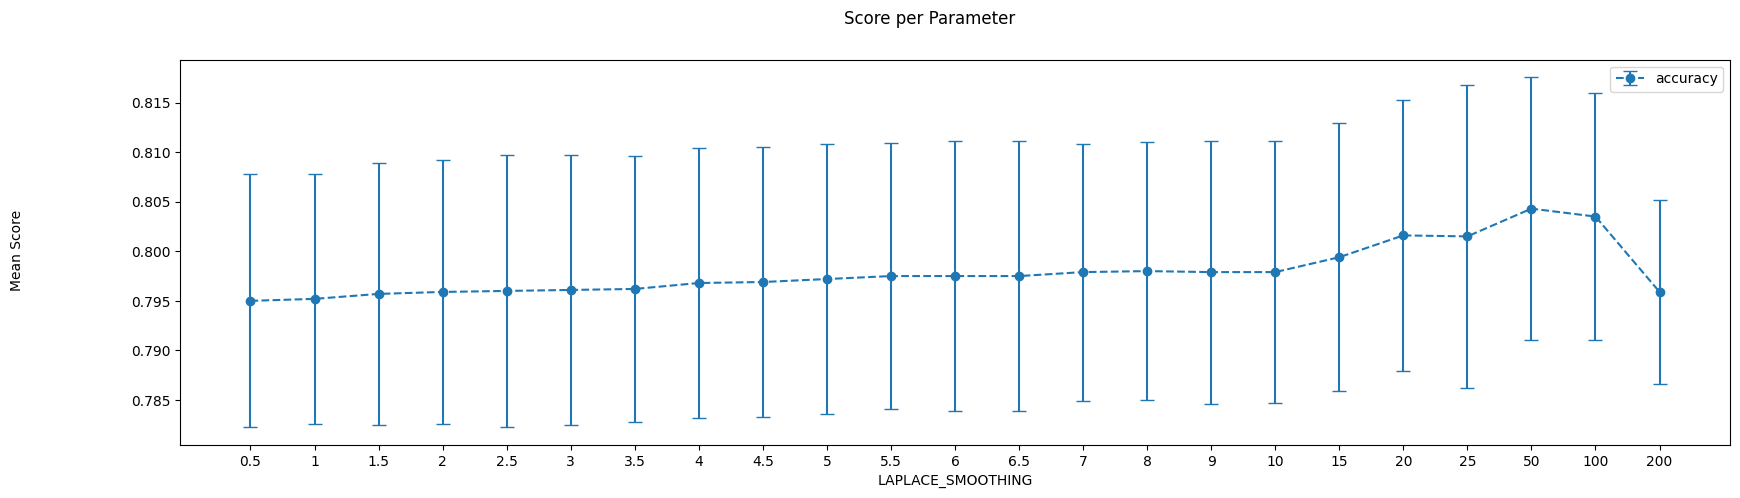

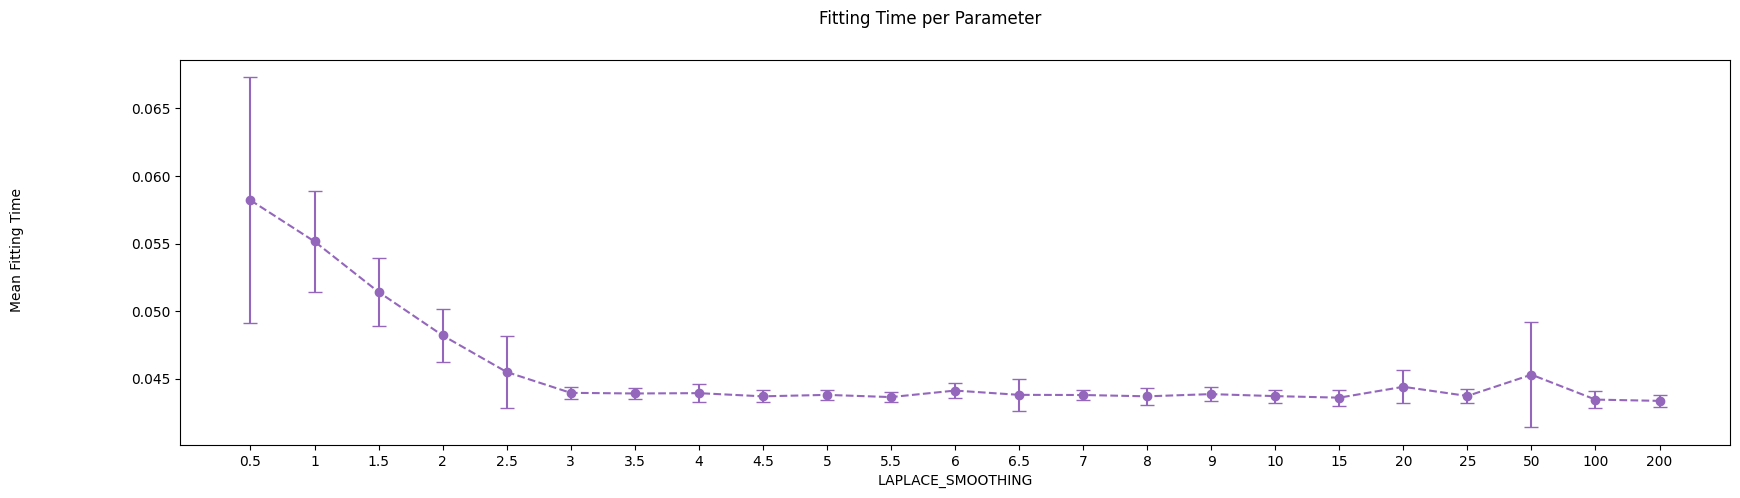

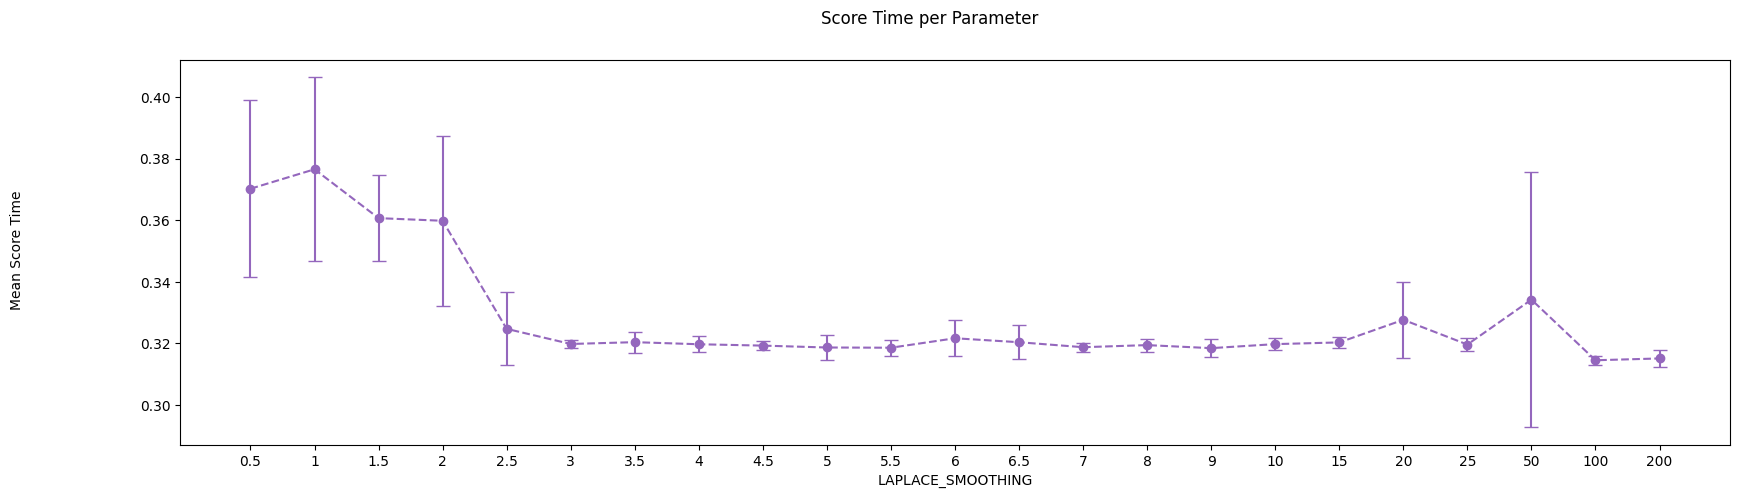

In [7]:
plot_gridsearch_scores(grid_car, ["accuracy"], strip_param_prefix="m__", plot_stds=True)

### 2.2 Amazon Reviews

In [8]:
mask = [False]*X_amazon.shape[1]
pipe = Pipeline([
    ('m', MixedNB(categorical_feature_mask=mask))
])
parameters = {
    "m__var_smoothing": [10e-9, 10e-6, 10e-3, 0.1, 1, 1.1]
}
grid_amazon = GridSearchCV(pipe, parameters,cv=kfold, scoring=["accuracy", "f1_macro", "precision_macro", "recall_macro"], refit="accuracy")
grid_amazon.fit(X_amazon, y_amazon)
print("Best params (our naive bayes): "  + str(grid_amazon.best_params_))

Best params (our naive bayes): {'m__var_smoothing': 0.01}


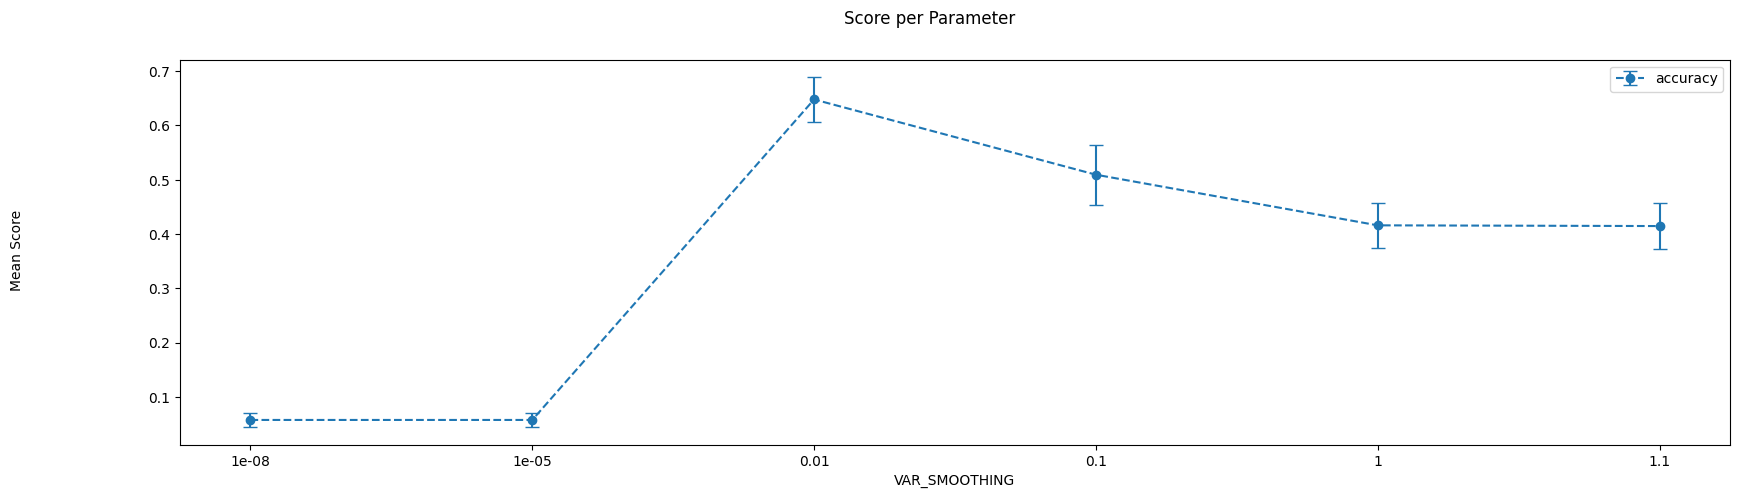

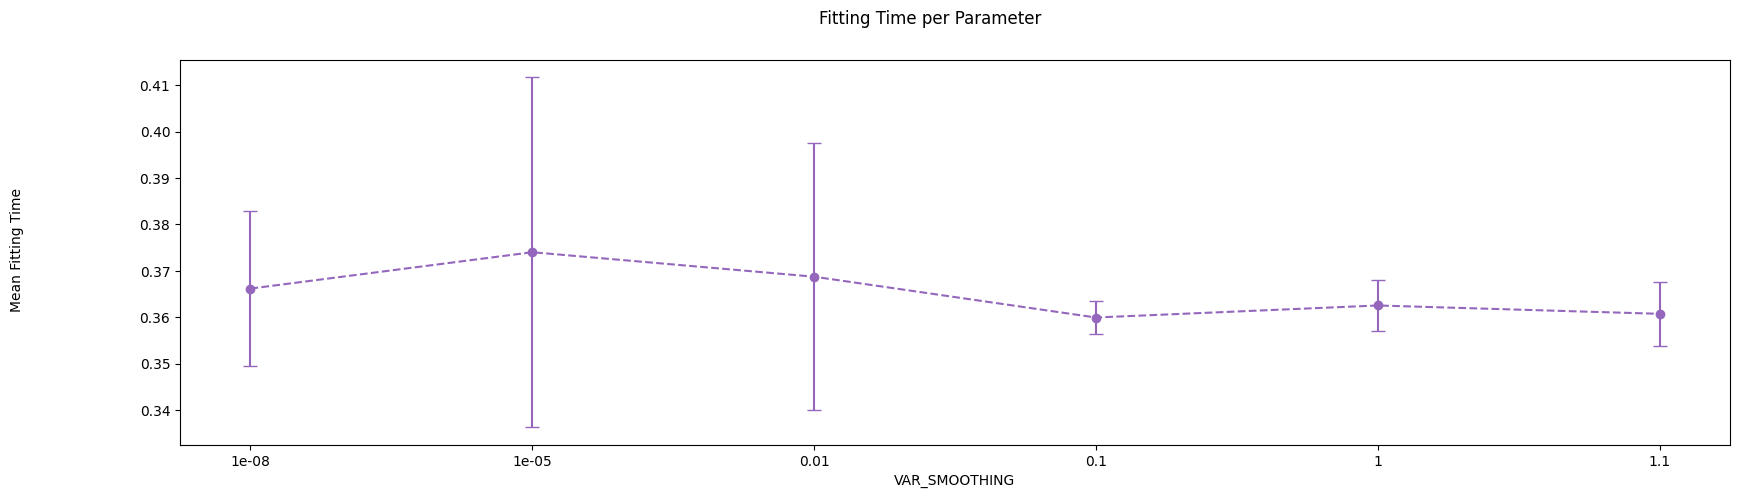

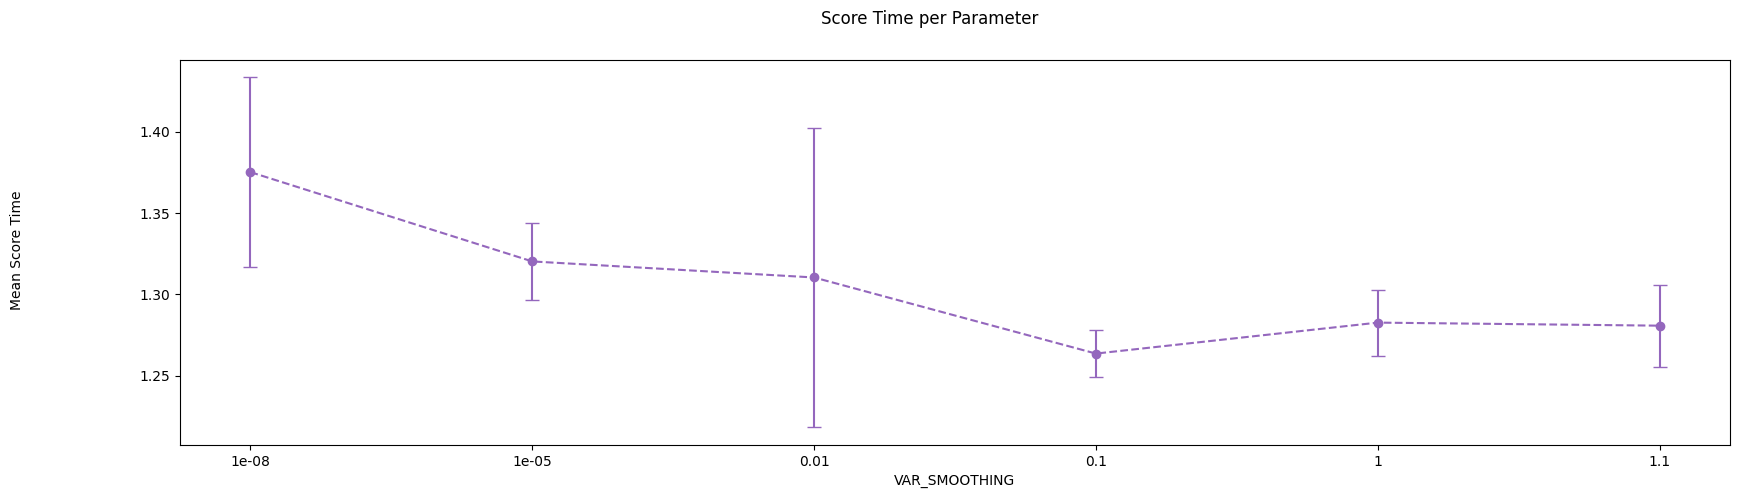

In [9]:
plot_gridsearch_scores(grid_amazon, ["accuracy"], strip_param_prefix="m__", plot_stds=True)

## 3. Compare Performance

### 3.1 Car Insurance Claims

**Our Naive Bayes**

In [10]:
mask = [True]*X_car.shape[1]
pipeline_nb_own = Pipeline([
    ('m', MixedNB(categorical_feature_mask=mask,laplace_smoothing=50))
])
scores_car_nb_own = cross_validate(pipeline_nb_own, X_car, y_car,error_score="raise",  scoring=["accuracy","f1_macro","precision_macro","recall_macro"])

**Sklearn Naive Bayes (CategoricalNB)**

In [11]:
pipeline_nb = Pipeline([
    ('m', CategoricalNB(min_categories=X_car.nunique(), alpha=50))
])
scores_car_nb = cross_validate(pipeline_nb, X_car, y_car, error_score="raise",  scoring=["accuracy","f1_macro","precision_macro","recall_macro"])

**Sklearn Random Forest**

In [12]:
pipeline_rf = Pipeline([
    ('m', RandomForestClassifier(random_state=SEED))
])
scores_car_rf = cross_validate(pipeline_rf, X_car, y_car,error_score="raise",  scoring=["accuracy","f1_macro","precision_macro","recall_macro"])

**Comparison**

In [13]:
print_results_table([scores_car_nb_own, scores_car_nb, scores_car_rf], headings=["our_nb", "sklearn_nb", "sklearn_rf"])

                          our_nb           sklearn_nb       sklearn_rf       
avg. accuracy:            0.8047           0.7956           0.8115           
avg. f1_macro:            0.7666           0.7679           0.7777           
avg. precision_macro:     0.7758           0.7630           0.7826           
avg. recall_macro:        0.7597           0.7746           0.7741           
avg. avg. fitting time:   0.0437           0.0048           0.3848           
avg. avg. score time:     0.6295           0.0059           0.0312           


### 3.2 Amazon Reviews

**Our Naive Bayes**

In [14]:
mask = [False]*X_amazon.shape[1]
model = MixedNB(categorical_feature_mask=mask, var_smoothing=0.01)
scores_amazon_nb_own = cross_validate(model, X_amazon, y_amazon, cv=kfold, scoring=["accuracy","f1_macro","precision_macro","recall_macro"])

**Sklearn Naive Bayes (GaussianNB)**

In [15]:
model = GaussianNB(var_smoothing=0.01)
scores_amazon_nb = cross_validate(model, X_amazon, y_amazon, cv=kfold, scoring=["accuracy","f1_macro","precision_macro","recall_macro"])

**Sklearn Random Forest**

In [16]:
model = RandomForestClassifier(random_state=SEED)
scores_amazon_rf = cross_validate(model, X_amazon, y_amazon, cv=kfold, scoring=["accuracy","f1_macro","precision_macro","recall_macro"])

**Comparison**

In [17]:
print_results_table([scores_amazon_nb_own, scores_amazon_nb, scores_amazon_rf], headings=["our_nb", "sklearn_nb", "sklearn_rf"])

                          our_nb           sklearn_nb       sklearn_rf       
avg. accuracy:            0.6480           0.6480           0.6107           
avg. f1_macro:            0.5881           0.5881           0.5505           
avg. precision_macro:     0.5849           0.5849           0.5505           
avg. recall_macro:        0.6442           0.6442           0.6016           
avg. avg. fitting time:   0.3635           0.0672           1.5089           
avg. avg. score time:     1.2796           0.1431           0.0107           
